In [110]:
import cv2
import wfdb as wf
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

In [26]:
# Prepare data access
paths = glob('data/mitdb/*.dat')
paths = [path[:-4] for path in paths]
paths.sort()

# We want only the [beat annotations](http://www.physionet.org/physiobank/annotations.shtml), each as 240 points

In [27]:
beat_annotations = ['N', 'L', 'R', 'B',
                    'A', 'a', 'J', 'S', 'V',
                    'r', 'F', 'e', 'j', 'n',
                    'E', '/', 'f', 'Q', '?'] 
# 0.5 of how much signal we want per beat
half_qrs = 120


# Convert all of the data into classified fragments

In [51]:
# Prepare the final container
base = pd.DataFrame()

for path in tqdm(paths):
    # print 'Working with file:', path
    ann = wf.rdann(path, 'atr')
    record = wf.rdsamp(path)
    
    # We want just the signals
    data = record.p_signals
    
    # Prepare containers
    signals, classes = [], []
    
    # Beat extraction
    for it, beat in enumerate(ann.anntype):
        if beat in beat_annotations:
            sta = ann.annsamp[it] - half_qrs
            end = ann.annsamp[it] + half_qrs
            qrs = data[sta : end, :]
            
            # This may happen at the edges
            if len(qrs) != 2 * half_qrs: continue
            
            # Keep the channel type in the class name
            for ch in range(2):
                beat_class = '{}_{}'.format(record.signame[ch], beat)
                signals.append(qrs[:, ch])
                classes.append(beat_class)
                
    new_frame = pd.DataFrame({'qrs_data' : signals,
                              'qrs_type' : classes})
    # Cumulate
    base = base.append(new_frame)

100%|██████████| 48/48 [00:20<00:00,  2.15it/s]


# Let's see what kinds of qrs types are available
We only want examples with more than 200 occurances

In [105]:
classes = base['qrs_type'].value_counts()
ids = classes.iloc[:] > 500
classes = classes.loc[ids]

# Show just the top ten
print classes[:10], classes.shape

MLII_N    74765
V1_N      65579
V1_L       8071
MLII_L     8071
MLII_R     7257
MLII_V     7123
V1_V       7029
V5_N       5833
V1_R       5726
V2_N       3877
Name: qrs_type, dtype: int64 (21,)


In [108]:
# Extract just one exemplary qrs
qrs_type = classes.index[4]
ids = base['qrs_type'] == qrs_type

# Get all of that type
partial = base.loc[ids]

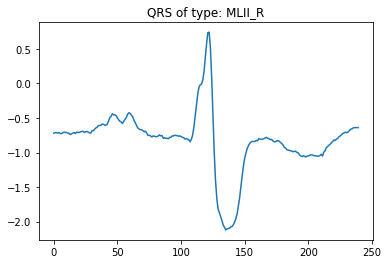

In [129]:
qrs = partial.iloc[123]['qrs_data']
plt.plot(qrs)
plt.title('QRS of type: {}'.format(qrs_type))

## Pure genius transformation of 1D signals into RGB images

In [148]:
# Stretch helper
def stretch(qrs, final_length):
    xa = np.linspace(0, 1, len(qrs))
    xb = np.linspace(0, 1, final_length)
    
    longer = np.interp(xb, xa, qrs)
    
    return longer

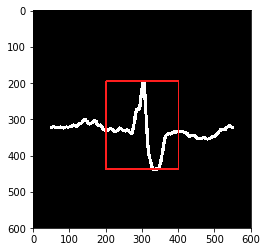

In [170]:
# Reload
qrs = partial.iloc[143]['qrs_data']

height = 400
scale_factor = 4
top_offset = 160 + np.random.randint(-40, 40)
left_offset = 50

# What what
qrs = stretch(qrs, 500)

# Rescale the qrs (and flip)
qrs = -qrs
qrs -= qrs.min()
qrs /= scale_factor

# Prepare to be and y-position
qrs = qrs * height
qrs = qrs.astype('uint16')
qrs += top_offset

# Extract the box
top = qrs.min()
bot = qrs.max()
left = 300 - 100
right = 300 + 100

# Must be tuple
pt1 = (right, top)
pt2 = (left, bot)

# Prepare the width dimension
x = left_offset + np.arange(len(qrs))

# Merge into draw-able points
points = zip(x, qrs)
points = np.array(points)

# Prepare an empty image
img = np.zeros([600, 600, 3], dtype = 'uint8')

# Draw on the canvas
cv2.polylines(img, [points], False, (255,255,255), thickness = 7)

# Add a bounnding box
cv2.rectangle(img, pt1, pt2, (255, 30, 30), thickness = 4)
plt.imshow(img)